In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import time
import numpy as np
from matplotlib import pyplot as plt
import uuid
import cv2

In [2]:
IMAGE_PATH = os.path.join('data', 'images')
LABEL_PATH = os.path.join('data', 'labels') 
if not os.path.exists(IMAGE_PATH):
    os.makedirs(IMAGE_PATH)
if not os.path.exists(LABEL_PATH):
    os.makedirs(LABEL_PATH)
else:
    pass

number_images = 75

In [3]:
cap = cv2.VideoCapture(0)

for imgnum in range(number_images):
    print(f'Collecting image {imgnum}')
    ret, frame = cap.read()
    imgname = os.path.join(IMAGE_PATH, f'{ str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow("Live Feed", frame)
    time.sleep(1)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()
    

In [2]:
GPU = tf.config.list_physical_devices('GPU')
CPU = tf.config.list_physical_devices('CPU')

print(f'Available GPU/s: {len(GPU)}')
print(f'Available CPU/s: {len(CPU)}')

Available GPU/s: 1
Available CPU/s: 1


In [5]:
images = tf.data.Dataset.list_files(os.path.join(IMAGE_PATH, '*.jpg'), shuffle=False)    

In [6]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    decode_img = tf.io.decode_jpeg(byte_img)
    return decode_img

In [7]:
images = images.map(load_image)

In [8]:
images.as_numpy_iterator().next()

In [9]:
image_generator = images.batch(4).as_numpy_iterator()
plot_images = image_generator.next()

In [10]:
fig, ax = plt.subplots(ncols = 4, figsize=(20, 20))

for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)

plt.show()

In [11]:
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):

        filename = file.split('.')[0]+'.json'         
        existing_filepath = os.path.join('data', 'labels', filename)

        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)

In [12]:
import albumentations as alb
import json

In [13]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height = 450), 
            alb.HorizontalFlip(p=0.5), 
            alb.RandomBrightnessContrast(p=0.2), 
            alb.RandomGamma(p=0.2), 
            alb.RGBShift(p=0.2), 
            alb.VerticalFlip(p=0.5)], 
            bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

In [14]:
img = cv2.imread(os.path.join('data', 'train', 'images', '2b974b39-9799-11ed-ba69-98af65b62569.jpg'))

In [15]:
with open(os.path.join('data', 'train', 'labels', '2b974b39-9799-11ed-ba69-98af65b62569.json'), 'r') as f:
    label = json.load(f)


In [16]:
coords = [0, 0, 0, 0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [17]:
coords

In [18]:
coords = list(np.divide(coords, [640, 480, 640, 480]))

In [19]:
coords

In [20]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [21]:
cv2.rectangle(augmented['image'],
            tuple(np.multiply(augmented['bboxes'][0][:2], [450, 450]).astype(int)),
            tuple(np.multiply(augmented['bboxes'][0][2:], [450, 450]).astype(int)),
            (255, 0, 0), 2)

plt.imshow(cv2.cvtColor(augmented['image'], cv2.COLOR_BGR2RGB))

In [22]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

In [23]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120, 120)))
train_images = train_images.map(lambda x: x/255)

In [24]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120, 120)))
test_images = test_images.map(lambda x: x/255)

In [25]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120, 120)))
val_images = val_images.map(lambda x: x/255)

In [26]:
train_images.as_numpy_iterator().next()

array([[[1.        , 1.        , 0.99215686],
        [1.        , 1.        , 0.99215686],
        [1.        , 1.        , 0.99215686],
        ...,
        [0.9766809 , 0.91785735, 0.8355044 ],
        [0.9597516 , 0.9009281 , 0.810732  ],
        [0.959734  , 0.8969889 , 0.80679286]],

       [[1.        , 1.        , 0.99215686],
        [1.        , 1.        , 0.99215686],
        [1.        , 1.        , 0.99215686],
        ...,
        [0.9381117 , 0.8753666 , 0.78517056],
        [0.9232668 , 0.86052173, 0.77032566],
        [0.914426  , 0.8438378 , 0.7575633 ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.89304787, 0.8263812 , 0.74794984],
        [0.89002097, 0.81943274, 0.74100137],
        [0.8959909 , 0.8254027 , 0.74119484]],

       ...,

       [[0.9911235 , 0.993015  , 0.97050065],
        [0.9882353 , 0.9880601 , 0.9665791 ],
        [0.9921568 , 0

In [27]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [28]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [29]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [30]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [31]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.1375, 0.3008, 0.61  , 0.9277], dtype=float16))

In [32]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(7200, 7200, 900, 900, 900, 900)

In [33]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [34]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [35]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [36]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.319  , 0.2156 , 0.5347 , 0.4905 ],
        [0.677  , 0.5093 , 0.959  , 0.8433 ],
        [0.4968 , 0.179  , 0.7793 , 0.5127 ],
        [0.5615 , 0.10834, 0.8394 , 0.4604 ],
        [0.5522 , 0.1772 , 0.992  , 0.651  ],
        [0.329  , 0.09973, 0.741  , 0.617  ],
        [0.2096 , 0.     , 0.7144 , 0.4885 ],
        [0.3252 , 0.2595 , 0.832  , 0.8467 ]], dtype=float16))

In [37]:
data_samples = train.as_numpy_iterator()

In [38]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


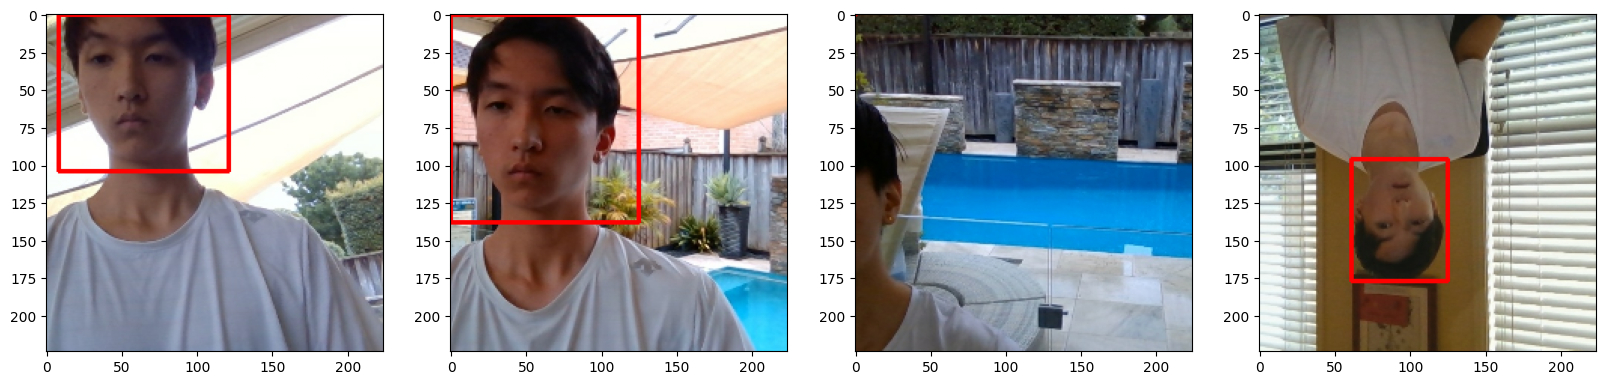

In [39]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [40]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [41]:
vgg = VGG16(include_top=False)

In [42]:
def build_model(): 
    input_layer = Input(shape=(120, 120,3))
    
    vgg = VGG19(include_top=False, weights='imagenet')(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box modellabel
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facedetector = Model(inputs=input_layer, outputs=[class2, regress2])
    return facedetector

In [43]:
facedetector = build_model()
facedetector.summary()
X, y = train.as_numpy_iterator().next()
X.shape
classes, coords = facedetector.predict(X)
classes, coords

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg19 (Functional)             (None, None, None,   20024384    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg19[0][0]']                  
 xPooling2D)                                                                                  

(array([[0.37971166],
        [0.46066824],
        [0.38056138],
        [0.46990702],
        [0.38104948],
        [0.5006389 ],
        [0.33014876],
        [0.34794277]], dtype=float32),
 array([[0.5613313 , 0.59407425, 0.2840048 , 0.16827595],
        [0.50673527, 0.62969124, 0.39003408, 0.27325553],
        [0.57935506, 0.41405535, 0.30599546, 0.23795633],
        [0.5318712 , 0.66597235, 0.35819715, 0.28081423],
        [0.5475371 , 0.56947136, 0.31833538, 0.22335711],
        [0.48992994, 0.5687562 , 0.3360316 , 0.27511635],
        [0.39554974, 0.5567661 , 0.35242188, 0.18555304],
        [0.452481  , 0.52609515, 0.32532975, 0.1719718 ]], dtype=float32))

In [44]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [45]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [46]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [47]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [48]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=8.111412>

In [49]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.84977573>

In [50]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=8.111412>

In [51]:
class FaceDetector(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [52]:
model = FaceDetector(facedetector)
model.compile(opt, classloss, regressloss)

In [53]:
logdir='logs'

In [54]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [55]:
hist = model.fit(train, epochs=5, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/5
900/900 [==============================] - 151s 159ms/step - total_loss: 0.3229 - class_loss: 0.0624 - regress_loss: 0.2917 - val_total_loss: 0.1223 - val_class_loss: 5.0664e-07 - val_regress_loss: 0.1223
Epoch 2/5
900/900 [==============================] - 145s 157ms/step - total_loss: 0.0520 - class_loss: 0.0063 - regress_loss: 0.0489 - val_total_loss: 0.0444 - val_class_loss: 7.9275e-06 - val_regress_loss: 0.0444
Epoch 3/5
900/900 [==============================] - 145s 156ms/step - total_loss: 0.0331 - class_loss: 0.0029 - regress_loss: 0.0317 - val_total_loss: 0.0919 - val_class_loss: 1.9014e-05 - val_regress_loss: 0.0919
Epoch 4/5
900/900 [==============================] - 150s 162ms/step - total_loss: 0.0123 - class_loss: 7.7215e-04 - regress_loss: 0.0119 - val_total_loss: 0.0292 - val_class_loss: 3.0398e-06 - val_regress_loss: 0.0292
Epoch 5/5
900/900 [==============================] - 149s 160ms/step - total_loss: 0.0088 - class_loss: 6.6170e-04 - regress_loss: 0.008

In [56]:
hist.history

{'total_loss': [0.09303082525730133,
  0.13660573959350586,
  0.014463051222264767,
  0.009152772836387157,
  0.003989405930042267],
 'class_loss': [3.7253203117870726e-06,
  0.07263883203268051,
  0.00029436370823532343,
  9.37425356823951e-05,
  4.626450390787795e-05],
 'regress_loss': [0.0930289626121521,
  0.1002863198518753,
  0.01431586965918541,
  0.00910590123385191,
  0.003966273739933968],
 'val_total_loss': [0.12234452366828918,
  0.04441731423139572,
  0.09193585813045502,
  0.029227331280708313,
  0.016942091286182404],
 'val_class_loss': [5.066397079644958e-07,
  7.927461410872638e-06,
  1.9014289136976004e-05,
  3.039846205865615e-06,
  3.635895609477302e-06],
 'val_regress_loss': [0.12234427034854889,
  0.04441335052251816,
  0.09192635118961334,
  0.02922581136226654,
  0.016940273344516754]}

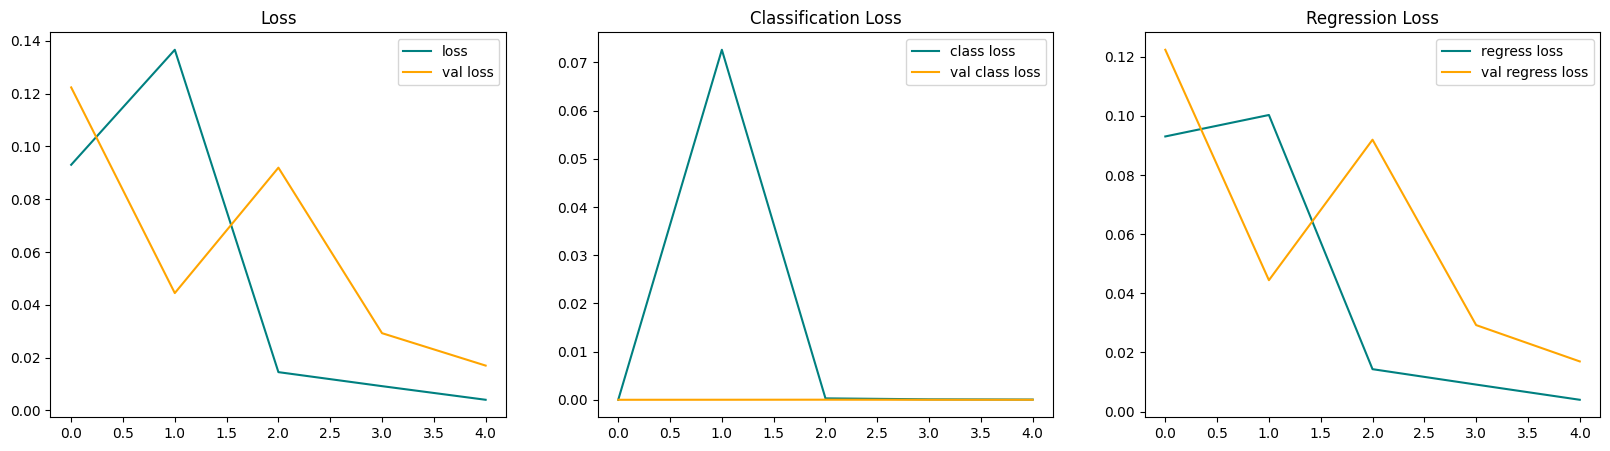

In [57]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [60]:
from tensorflow.keras.models import load_model
facedetector.save('VGG16.h5')

In [61]:
facetracker = load_model('VGG16.h5')

In [68]:
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 720)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)


while cap.isOpened():
    _ , frame = cap.read()
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120, 120))
    yhat = facedetector.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [720, 720]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [720, 720]).astype(int)), 
                            (255,0,0), 2)
    
    cv2.imshow('Reak Time', cv2.flip(frame, 1))
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 19ms/step
